### Student Performance from Game Play Using TensorFlow Decision Forests

### `Import the Required Libraries`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf

### `Load the Dataset & Modify DataTypes for better performance`

* `int32 is much lighter than int64`
* `float32 is much lighter than float64`
* `Categorty datatype is much better than object datatype`

In [2]:
## Modify DataTypes of the columns
cols_dtypes={
                'elapsed_time':np.int32,
                'event_name':'category',
                'name':'category',
                'level':np.uint8,
                'room_coor_x':np.float32,
                'room_coor_y':np.float32,
                'screen_coor_x':np.float32,
                'screen_coor_y':np.float32,
                'hover_duration':np.float32,
                'text':'category',
                'fqid':'category',
                'room_fqid':'category',
                'text_fqid':'category',
                'fullscreen':'category',
                'hq':'category',
                'music':'category',
                'level_group':'category'}

df_train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=cols_dtypes)
print('The Shape of Training Dataset is:', df_train.shape)

The Shape of Training Dataset is: (26296946, 20)


#### `Comment: The data is composed of 20 columns and 26296946 entries.`

In [3]:
## Check the head
df_train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [4]:
## Check the Info for the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int64   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           uint8   
 6   page            float64 
 7   room_coor_x     float32 
 8   room_coor_y     float32 
 9   screen_coor_x   float32 
 10  screen_coor_y   float32 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      category
 17  hq              category
 18  music           category
 19  level_group     category
dtypes: category(10), float32(5), float64(1), int32(1), int64(2), uint8(1)
memory usage: 1.5 GB


### Load the labels

* `The labels for the training dataset are stored in the **train_labels.csv**`.
* `It consists of the information on whether the user in a particular session answered each question correctly.`

In [5]:
## Load the labels file
data_labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
data_labels.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [6]:
## Split the (session_id) to both the session and number of question
data_labels['session'] = data_labels['session_id'].apply(lambda x: int(x.split('_')[0]))
data_labels['question'] = data_labels['session_id'].apply(lambda x: int(x.split('_')[-1][1:]))  ## the number of question
data_labels.head()

,session_id,correct,session,question
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


#### `Our goal is to train models for each question to predict the label `correct` for any input user session.`

### `Visualization`

#### `CountPlot for correct column in all dataset`

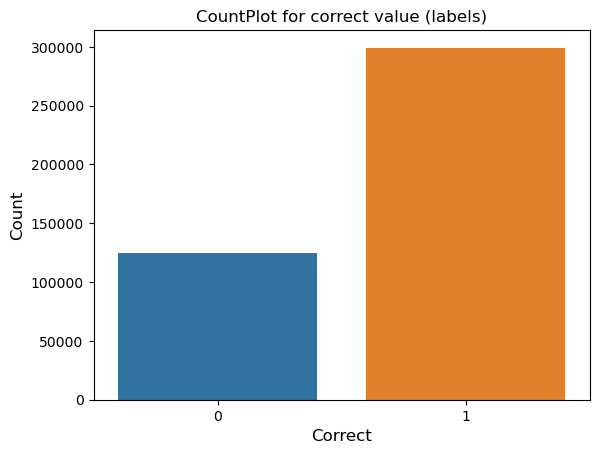

In [7]:
## CountPlot for correct column in labels
sns.countplot(x='correct', data=data_labels)
plt.title('CountPlot for correct value (labels)', fontsize=12, color='k')
plt.xlabel('Correct', fontsize=12, color='k')
plt.ylabel('Count', fontsize=12, color='k')
plt.show()

#### `plot countplot for correct column (labels) for each question`

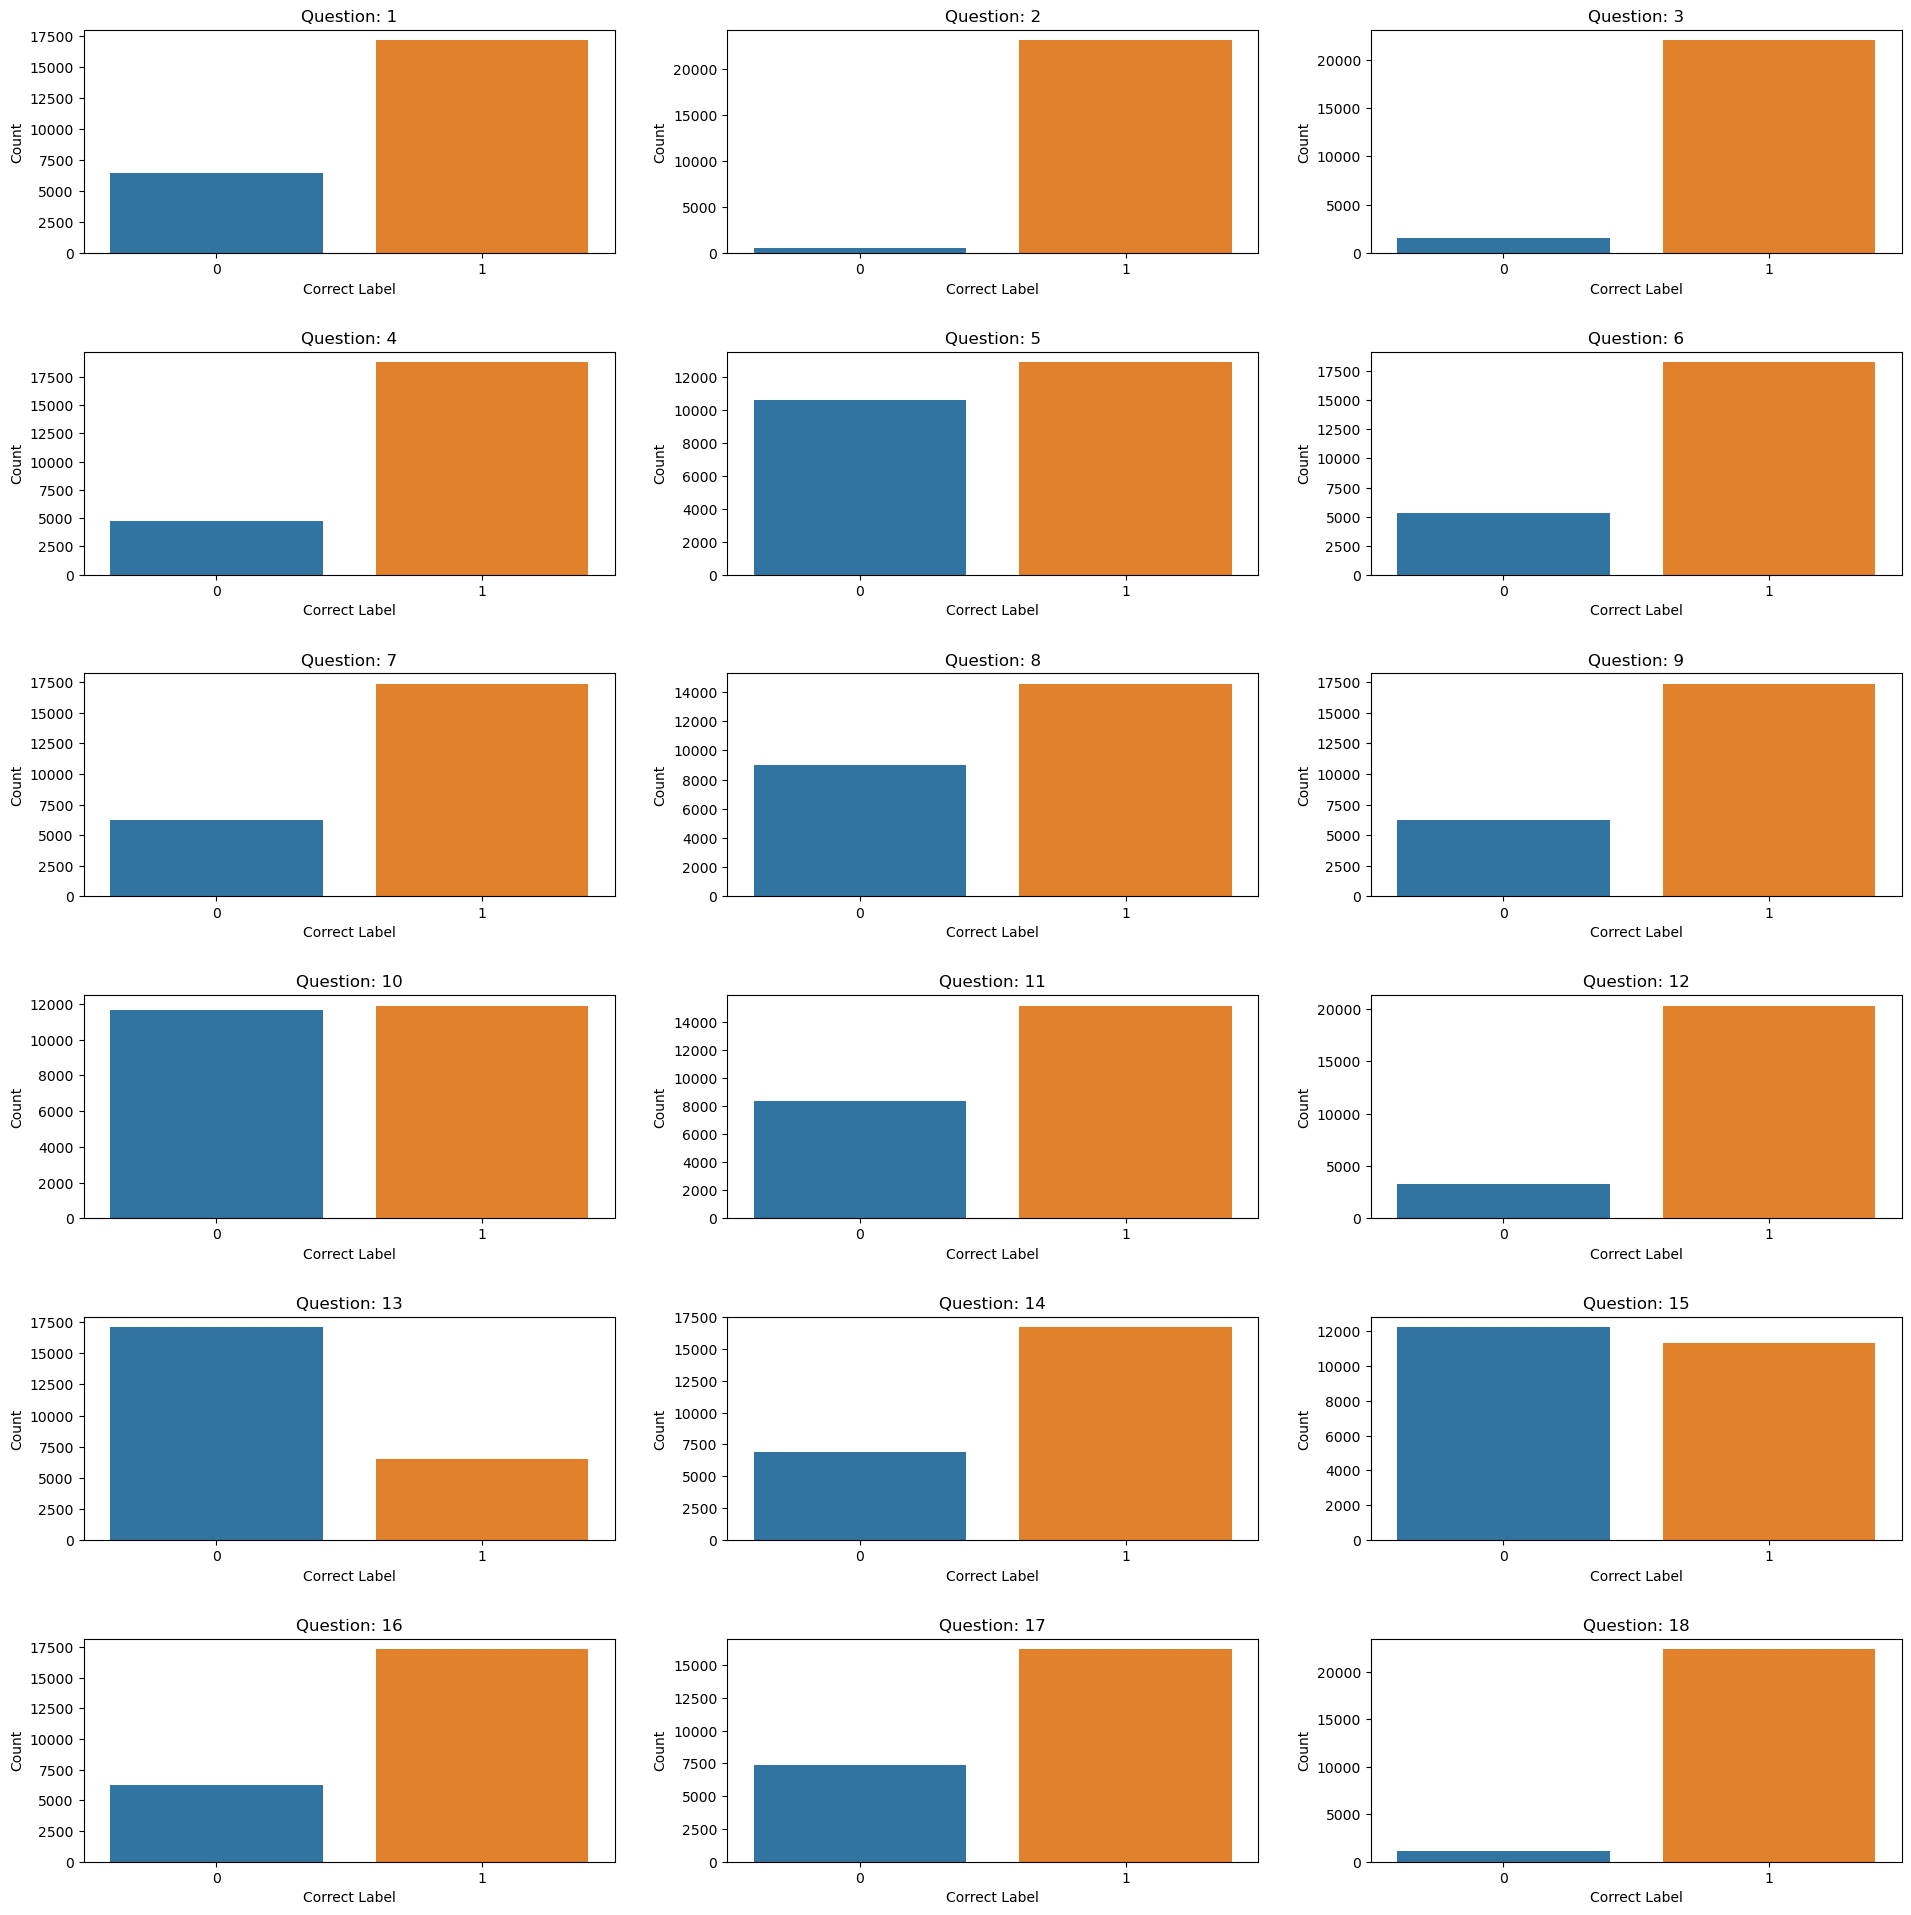

In [8]:
## plot the values of correct column (labels) for each question.
q_num = data_labels['question'].unique().reshape(6, 3)
fig, ax = plt.subplots(6, 3, figsize=(20, 20))
fig.tight_layout(pad=5)
for row in range(6):
    for col in range(3):
        plt.sca(ax[row, col])
        sns.countplot(x=data_labels[data_labels['question']==q_num[row, col]]['correct'])
        plt.xlabel('Correct Label')
        plt.ylabel('Count')
        plt.title(f'Question: {q_num[row, col]}')

### `Data Preprocessing`

As summarized in the competition overview, the dataset presents the questions and data to us in order of `levels - level segments`(represented by column `level_group`) 0-4, 5-12, and 13-22. We have to predict the correctness of each segment's questions as they are presented. To do this we will create basic aggregate features from the relevant columns. You can create more features to boost your scores. 

First, we will create two separate lists with names of the Categorical columns and Numerical columns. Taking more features

#### `Feature Engineering`

In [9]:
## Take only the features you interested in
categ_cols = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
num_cols = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

For each categorical column, we will first group the dataset by `session_id`  and `level_group`. We will then count the number of **distinct elements** in the column for each group and store it temporarily.

For all numerical columns, we will group the dataset by `session id` and `level_group`. Instead of counting the number of distinct elements, we will calculate the `mean` and `standard deviation` of the numerical column for each group and store it temporarily.

After this, we will concatenate the temporary data frames we generated in the earlier step for each column to create our new feature engineered dataset.

In [10]:
df_train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [11]:
## Note: there are duplicaets
df_train[df_train[['session_id']].duplicated()]

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
5,20090312431273200,5,3423,person_click,basic,0,NaN,-412.991394,-157.314682,381.0,492.0,NaN,"Sure thing, Jo. Grab your notebook and come up...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26296941,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887299,36.701027,483.0,273.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,0,0,1,13-22
26296942,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696075,141.493179,545.0,221.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22
26296943,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912872,140.569199,611.0,217.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,0,0,1,13-22
26296944,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299652,123.805893,526.0,232.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22


In [12]:
## Feature Engineering Function
## For each Categorical column -- get the number of unique values in it after grouping by (session_id & level_group)
## For each Numerical column -- get mean & std after grouping by (session_id & level_group)
def feature_engineering(dataset):
    dfs = []
    for c in categ_cols:
        tmp = dataset.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in num_cols:
        tmp = dataset.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in num_cols:
        tmp = dataset.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
        
    ## Concatenate all of them finally
    dataset_df = pd.concat(dfs, axis=1)
    ## Choossing to fill NaNs by (-1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    
    return dataset_df

In [13]:
## Call the function
df_train_new = feature_engineering(dataset=df_train)
print('The shape of processed Training Dataset is:', df_train_new.shape)

The shape of processed Training Dataset is: (70686, 22)


In [14]:
## Check the head of it
df_train_new.head()

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044861,2389.500000,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347168,...,379.301025,899.925903,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784912,969.333313,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045959,...,370.723083,1378.750000,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762283,...,387.930084,720.384949,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


#### `Comment: Our feature engineered dataset is composed of 22 columns and 70686 entries. `

In [15]:
## Describe the New Dataset
df_train_new.describe()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
count,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,...,70686.000000,7.068600e+04,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04
mean,10.390021,3.885324,40.468650,10.268908,23.838412,2.811806e+06,9.311221,1.439995,-33.454849,-92.222832,...,379.749146,4.119625e+03,9.322398e+05,1.916549,0.038805,468.689088,183.186301,240.795420,124.016602,1.322598e+04
std,0.832923,0.799293,13.020929,2.928351,8.989095,2.289877e+07,6.523788,2.350494,80.784378,69.349052,...,36.971046,1.394260e+05,1.206491e+07,0.492239,0.785170,106.991644,48.884988,28.709135,15.844603,4.868272e+05
min,7.000000,3.000000,18.000000,5.000000,8.000000,4.591262e+02,0.923372,-1.000000,-461.440735,-409.231293,...,177.051849,-1.000000e+00,2.337003e+02,0.684670,-1.000000,261.425412,90.098533,109.415466,68.257406,-1.000000e+00
25%,10.000000,3.000000,25.000000,7.000000,15.000000,1.642777e+05,2.051613,-1.000000,-90.615677,-151.717484,...,358.117455,9.709706e+02,8.240024e+04,1.295298,-1.000000,381.066225,143.588600,222.569734,113.994303,1.368802e+03
50%,11.000000,4.000000,43.000000,11.000000,23.000000,5.882137e+05,8.140526,1.000000,-20.255626,-71.538727,...,377.843857,1.427761e+03,1.440869e+05,2.099711,0.000000,431.901352,162.941973,238.383832,122.388964,2.041432e+03
75%,11.000000,4.000000,51.000000,12.000000,32.000000,1.351434e+06,17.592593,4.000000,23.220109,-38.693486,...,397.018394,2.158794e+03,2.240529e+05,2.316163,0.735893,585.347609,233.385259,255.083349,132.067430,3.105588e+03
max,11.000000,6.000000,81.000000,17.000000,48.000000,1.191886e+09,20.222101,6.000000,328.096100,160.347992,...,986.192993,2.772298e+07,9.946229e+08,3.580235,2.715695,817.257133,349.049304,612.958607,331.833790,7.837739e+07


### `Check TimeSeries Distribution`
> It is a TimeSeries Distribution

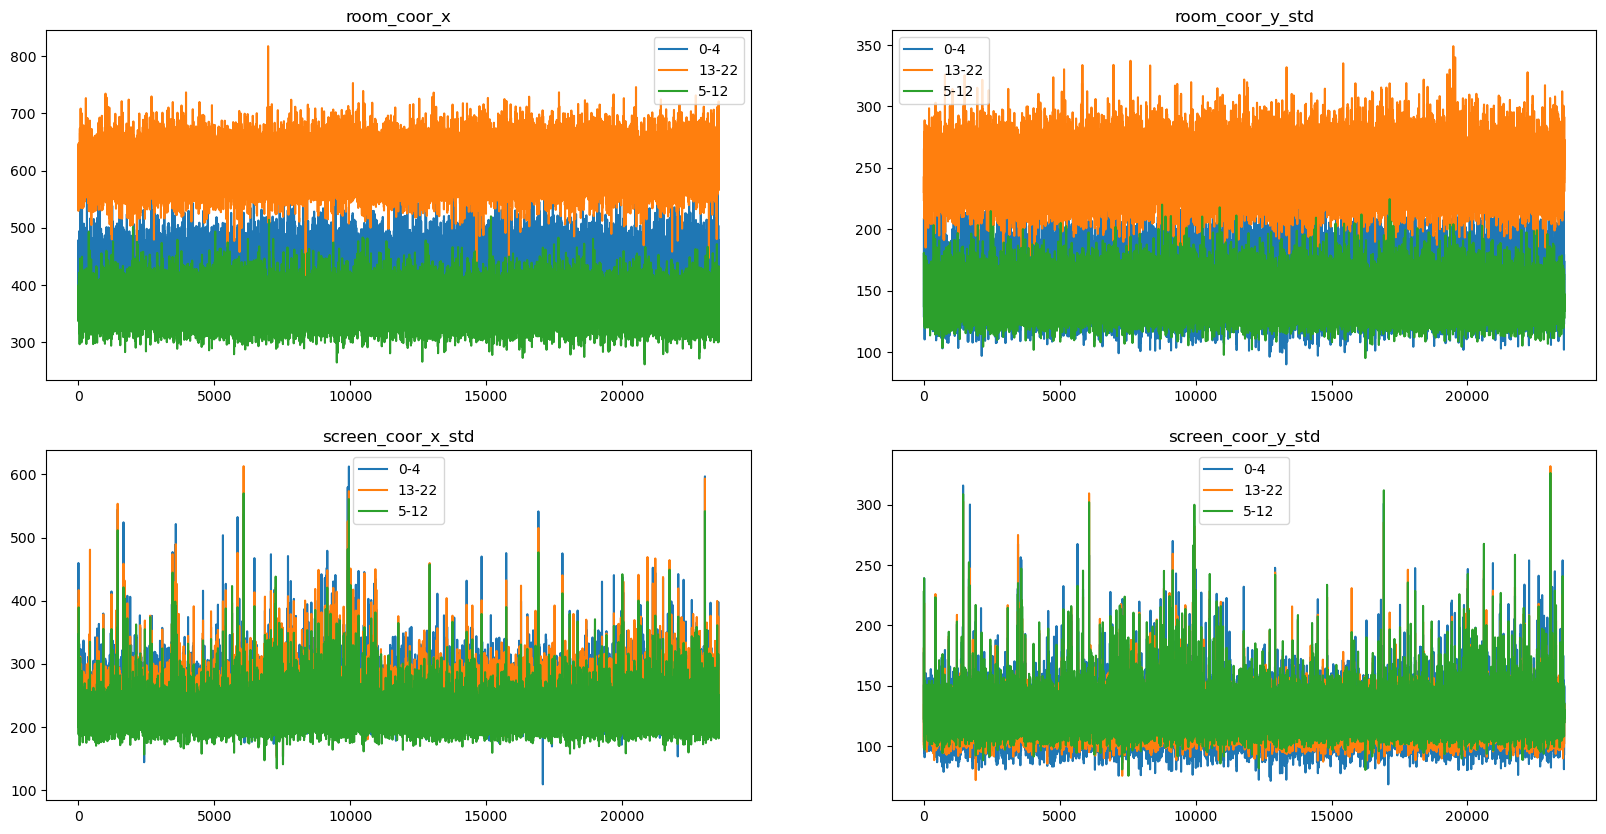

In [16]:
## TimeSeries Distributino for some Numerical Featuers after grouping (level_group)
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

for col, vals in df_train_new.groupby('level_group'):
    ax[0, 0].plot(range(1, len(vals['room_coor_x_std'])+1), vals['room_coor_x_std'], label=col)
    ax[0, 0].set_title('room_coor_x')
    ax[0, 0].legend()
    ax[0, 1].plot(range(1, len(vals['room_coor_y_std'])+1), vals['room_coor_y_std'], label=col)
    ax[0, 1].set_title('room_coor_y_std')
    ax[0, 1].legend()
    ax[1, 0].plot(range(1, len(vals['screen_coor_x_std'])+1), vals['screen_coor_x_std'], label=col)
    ax[1, 0].set_title('screen_coor_x_std')
    ax[1, 0].legend()
    ax[1, 1].plot(range(1, len(vals['screen_coor_y_std'])+1), vals['screen_coor_y_std'], label=col)
    ax[1, 1].set_title('screen_coor_y_std')
    ax[1, 1].legend()

### `Split the Dataset`

In [17]:
## Unique values for session_id
unique_users = df_train_new.index.unique()
print('Unique Session_id in the Dataset \t \n', unique_users)

Unique Session_id in the Dataset 	 
 Int64Index([20090312431273200, 20090312433251036, 20090312455206810,
            20090313091715820, 20090313571836404, 20090314035813970,
            20090314121766812, 20090314221187252, 20090314363702160,
            20090314441803444,
            ...
            22100213081672770, 22100213133089136, 22100215032067016,
            22100215190998610, 22100215241104530, 22100215342220508,
            22100215460321130, 22100217104993650, 22100219442786200,
            22100221145014656],
           dtype='int64', name='session_id', length=23562)


In [18]:
## Take the unique values of (session_id: index)

## 90% for Training, 10% for Validation
unique_users = df_train_new.index.unique()
cutoff = int(len(unique_users) * 0.9)

## Take first 80% of unique session_id for Train --- Then slice these session_id from the whold dataset (of course there are duplicated session_id)\
X_train = df_train_new.loc[unique_users[:cutoff]]

## Take last 20% of unique session_id for Valid --- Then slice these session_id from the whold dataset (of course there are duplicated session_id)\
X_valid = df_train_new.loc[unique_users[cutoff:]]

print('The Shape of Full Training Dataset is:', df_train_new.shape)
print('The Shape of Training Dataset is:', X_train.shape)
print('The Shape of Validatino Dataset is:', X_valid.shape)

The Shape of Full Training Dataset is: (70686, 22)
The Shape of Training Dataset is: (63615, 22)
The Shape of Validatino Dataset is: (7071, 22)


### `Model`

In [19]:
## Using TensorFlow for Decision Forest (light Models)
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

### `RandomForest Model`

* `I will train a model for each question to predict if the question will be answered correctly by a user.` 
* `There are a total of 18 questions in the dataset. Hence, we will be training 18 models, one for each question.`

In [20]:
## I want to make a prediction DataFrame for each session_id
## So, I make an empty dataframe indexed by session_id
users_list_valid = X_valid.index.unique()
data = np.zeros((len(users_list_valid), 18))
df_prediction = pd.DataFrame(data, index=users_list_valid)
df_prediction.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
22040211112628700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22040211114902108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22040211141496010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22040211164659920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22040211184188850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### `Note: I will create a Model for each question`

In [21]:
## Create an empty dictionary to store the models created for each question.
models = {}

## Create an empty dictionary to store the evaluation score for each question.
evaluation_valid ={}

Before training the data we have to understand how `level_groups` and `questions` are associated to each other.

In this game the first quiz checkpoint(i.e., questions 1 to 3) comes after finishing levels 0 to 4. So for training questions 1 to 3 we will use data from the `level_group` 0-4. Similarly, we will use data from the `level_group` 5-12 to train questions from 4 to 13 and data from the `level_group` 13-22 to train questions from 14 to 18.

We will train a model for each question and store the trained model in the `models` dict.

In [22]:
data_labels.head()

,session_id,correct,session,question
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [23]:
# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    ## Select level group for the question based on the q_no.
    if q_no <= 3: 
        grp = '0-4'
    elif q_no <=13 : 
        grp = '5-12'
    elif q_no <= 22: 
        grp = '13-22'
    print(f"Question Number: {q_no} & Group: {grp}")
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = X_train.loc[X_train['level_group'] == grp]
    train_users = train_df.index.values
    valid_df = X_valid.loc[X_valid['level_group'] == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = data_labels.loc[data_labels['question']==q_no].set_index('session').loc[train_users]
    valid_labels = data_labels.loc[data_labels['question']==q_no].set_index('session').loc[valid_users]

    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    ## We need to convert the datatset from Pandas format (pd.DataFrame) to TensorFlow
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    ## Create and compile the model
    cart = tfdf.keras.CartModel(verbose=0)
    cart.compile(metrics=["accuracy"])

    # Train the model.
    cart.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = cart

    ## Evaluate the trained model on the validation dataset
    inspector = cart.make_inspector()
    inspector.evaluation()
    evaluation = cart.evaluate(x=valid_ds, return_dict=True)
    evaluation_valid[q_no] = evaluation["accuracy"]         

    ## store the predicted values in the `df_prediction` dataframe.
    predict = cart.predict(x=valid_ds)
    df_prediction.loc[valid_users, q_no-1] = predict.flatten()     

Question Number: 1 & Group: 0-4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[INFO 2023-04-29T10:54:29.867210948+00:00 kernel.cc:1214] Loading model from path /tmp/tmpdmocdm35/model/ with prefix 709ec98fbc1a46da
[INFO 2023-04-29T10:54:29.875796806+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 345 node(s), and 21 input feature(s).
[INFO 2023-04-29T10:54:29.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3/3 [==============================] - 0s 10ms/step
Question Number: 2 & Group: 0-4


[INFO 2023-04-29T10:54:33.839874374+00:00 kernel.cc:1214] Loading model from path /tmp/tmp9ubbwmib/model/ with prefix c71f3b22f0944457
[WARNING 2023-04-29T10:54:33.840350398+00:00 utils.cc:73] The model does not have any input features i.e. the model is constant and will always return the same prediction.
[INFO 2023-04-29T10:54:33.840405357+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 1 node(s), and 0 input feature(s).
[INFO 2023-04-29T10:54:33.840476536+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 12ms/step
Question Number: 3 & Group: 0-4


[INFO 2023-04-29T10:54:35.952956718+00:00 kernel.cc:1214] Loading model from path /tmp/tmpzl29qgjv/model/ with prefix 1a2b0b0fb8e74faa
[INFO 2023-04-29T10:54:35.953786926+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 61 node(s), and 15 input feature(s).
[INFO 2023-04-29T10:54:35.95388933+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 12ms/step
Question Number: 4 & Group: 5-12


[INFO 2023-04-29T10:54:37.510956924+00:00 kernel.cc:1214] Loading model from path /tmp/tmpgdjw2vve/model/ with prefix 8ea2a09056bf45e1
[INFO 2023-04-29T10:54:37.513106887+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 395 node(s), and 21 input feature(s).
[INFO 2023-04-29T10:54:37.513249321+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 14ms/step
Question Number: 5 & Group: 5-12


[INFO 2023-04-29T10:54:39.643458007+00:00 kernel.cc:1214] Loading model from path /tmp/tmpr5et1g_d/model/ with prefix b6d230f1a26844a2
[INFO 2023-04-29T10:54:39.645859075+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 517 node(s), and 20 input feature(s).
[INFO 2023-04-29T10:54:39.645903911+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 13ms/step
Question Number: 6 & Group: 5-12


[INFO 2023-04-29T10:54:41.266407321+00:00 kernel.cc:1214] Loading model from path /tmp/tmpej5ekvz7/model/ with prefix 6fa2e0277ba54b69
[INFO 2023-04-29T10:54:41.268261527+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 371 node(s), and 20 input feature(s).
[INFO 2023-04-29T10:54:41.268300029+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T10:54:41.268325885+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 11ms/step
Question Number: 7 & Group: 5-12


[INFO 2023-04-29T10:54:42.842581741+00:00 kernel.cc:1214] Loading model from path /tmp/tmpbgs84k1p/model/ with prefix 5cee4ffab97c4a68
[INFO 2023-04-29T10:54:42.845672976+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 533 node(s), and 21 input feature(s).
[INFO 2023-04-29T10:54:42.846040349+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 11ms/step
Question Number: 8 & Group: 5-12


[INFO 2023-04-29T10:54:44.945174894+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0hhxie6t/model/ with prefix 8cac5a56d7ce4d83
[INFO 2023-04-29T10:54:44.947292349+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 383 node(s), and 21 input feature(s).
[INFO 2023-04-29T10:54:44.947337371+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 13ms/step
Question Number: 9 & Group: 5-12


[INFO 2023-04-29T10:54:46.607201119+00:00 kernel.cc:1214] Loading model from path /tmp/tmpuzvtfkpy/model/ with prefix c70b2f0eaf244b1a
[INFO 2023-04-29T10:54:46.608834173+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 279 node(s), and 19 input feature(s).
[INFO 2023-04-29T10:54:46.608878803+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 12ms/step
Question Number: 10 & Group: 5-12


[INFO 2023-04-29T10:54:49.00914047+00:00 kernel.cc:1214] Loading model from path /tmp/tmpv8ziq7hj/model/ with prefix 0b962c94b8f74896
[INFO 2023-04-29T10:54:49.011561832+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 515 node(s), and 20 input feature(s).
[INFO 2023-04-29T10:54:49.01160829+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 15ms/step
Question Number: 11 & Group: 5-12


[INFO 2023-04-29T10:54:50.597910291+00:00 kernel.cc:1214] Loading model from path /tmp/tmptouunnxa/model/ with prefix 5ea20cb1083c4117
[INFO 2023-04-29T10:54:50.600603986+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 441 node(s), and 20 input feature(s).
[INFO 2023-04-29T10:54:50.600658964+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 13ms/step
Question Number: 12 & Group: 5-12


[INFO 2023-04-29T10:54:52.685018387+00:00 kernel.cc:1214] Loading model from path /tmp/tmp5y4tnid8/model/ with prefix 1e82cd3b01f2494d
[INFO 2023-04-29T10:54:52.686246817+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 169 node(s), and 18 input feature(s).
[INFO 2023-04-29T10:54:52.686282717+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T10:54:52.686309074+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 10ms/step
Question Number: 13 & Group: 5-12


[INFO 2023-04-29T10:54:54.767618224+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0d7kw4pq/model/ with prefix 6553487292cc4a9a
[INFO 2023-04-29T10:54:54.769430665+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 317 node(s), and 20 input feature(s).
[INFO 2023-04-29T10:54:54.769478831+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 11ms/step
Question Number: 14 & Group: 13-22


[INFO 2023-04-29T10:54:56.339708916+00:00 kernel.cc:1214] Loading model from path /tmp/tmp29053x4j/model/ with prefix 388a7e06ba65420c
[INFO 2023-04-29T10:54:56.341849689+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 467 node(s), and 21 input feature(s).
[INFO 2023-04-29T10:54:56.341891043+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 9ms/step
Question Number: 15 & Group: 13-22


[INFO 2023-04-29T10:54:58.443472576+00:00 kernel.cc:1214] Loading model from path /tmp/tmpvrr4kjw5/model/ with prefix 3204271048594e8e
[INFO 2023-04-29T10:54:58.446360487+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 595 node(s), and 20 input feature(s).
[INFO 2023-04-29T10:54:58.446405955+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 12ms/step
Question Number: 16 & Group: 13-22


[INFO 2023-04-29T10:55:00.063924917+00:00 kernel.cc:1214] Loading model from path /tmp/tmpr5tlv7dw/model/ with prefix 6eb8d04605a44015
[INFO 2023-04-29T10:55:00.065849662+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 227 node(s), and 20 input feature(s).
[INFO 2023-04-29T10:55:00.065898009+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 11ms/step
Question Number: 17 & Group: 13-22


[INFO 2023-04-29T10:55:02.124115165+00:00 kernel.cc:1214] Loading model from path /tmp/tmplyp6o_ju/model/ with prefix 55e768d81f6b465c
[INFO 2023-04-29T10:55:02.125555842+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 217 node(s), and 19 input feature(s).
[INFO 2023-04-29T10:55:02.125600401+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 12ms/step
Question Number: 18 & Group: 13-22


[INFO 2023-04-29T10:55:04.201903741+00:00 kernel.cc:1214] Loading model from path /tmp/tmpiq_6e_z3/model/ with prefix e135abfd70f347ff
[INFO 2023-04-29T10:55:04.202581723+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 45 node(s), and 16 input feature(s).
[INFO 2023-04-29T10:55:04.202626568+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T10:55:04.202662244+00:00 kernel.cc:1046] Use fast generic engine


3/3 [==============================] - 0s 9ms/step


In [24]:
## Create and compile the model
cart = tfdf.keras.CartModel(verbose=0)
cart.compile(metrics=["accuracy"])

### `Inspect the Accuracy of the models.`

We trained a model for each question. Now let us check the accuracy of each model and overall accuracy for all the models combined. 

Note: Since the label distribution is imbalanced, we can't make an assumption on the model performance from accuracy score alone. 

In [25]:
## Check the Accuracy for each question, and overall accuracy
for name, value in evaluation_valid.items():
  print(f"question {name}: accuracy {value:.4f}")
print('***'*30)
print("Average accuracy: \t", sum(evaluation_valid.values())/18)

question 1: accuracy 0.7225
question 2: accuracy 0.0216
question 3: accuracy 0.9393
question 4: accuracy 0.7904
question 5: accuracy 0.6012
question 6: accuracy 0.7760
question 7: accuracy 0.7408
question 8: accuracy 0.6071
question 9: accuracy 0.7586
question 10: accuracy 0.5800
question 11: accuracy 0.6343
question 12: accuracy 0.8587
question 13: accuracy 0.7102
question 14: accuracy 0.7297
question 15: accuracy 0.5779
question 16: accuracy 0.7340
question 17: accuracy 0.6954
question 18: accuracy 0.9465
******************************************************************************************
Average accuracy: 	 0.6902371212426159


### `Visualize the model`

One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. 

Let us pick one model from `models` dict and select a tree to display below.

In [26]:
## Choose on of the Models
## Let us take the 2nd of (0-4 | the level-group)
tfdf.model_plotter.plot_model_in_colab(models['0-4_2'], tree_idx=0, max_depth=3)

### `Features Importances`

In [27]:
## Get the Feature Importance from the Model
inspector = models['0-4_2'].make_inspector()

print(f"Available Features Importances:")
for importance in inspector.variable_importances().keys():  
    print("\t", importance)

Available Features Importances:
	 SUM_SCORE
	 NUM_NODES
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH


`Usually, we care with (NUM_AS_ROOT), Number of each feature splitted with in the Model`

In [28]:
## Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[]

### `Threshold-Moving for Imbalanced Classification`
>Try to get the best threshold

In [29]:
## The Defualt threshold is (0.5)
## Try that for this Notebook
true_df = pd.DataFrame(data=np.zeros((len(users_list_valid),18)), index=users_list_valid)
for i in range(18):
    # Get the true labels.
    tmp = data_labels.loc[data_labels.question == i+1].set_index('session').loc[users_list_valid]
    true_df[i] = tmp.correct.values

max_score = 0
best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4, 0.8, 0.01):
    metric = tfa.metrics.F1Score(num_classes=2,average="macro",threshold=threshold)
    y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
    y_pred = tf.one_hot((df_prediction.values.reshape((-1))>threshold).astype('int'), depth=2)
    metric.update_state(y_true, y_pred)
    f1_score = metric.result().numpy()
    if f1_score > max_score:
        max_score = f1_score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

Best threshold  0.6200000000000002 	F1 score  0.61030924


### `Submission`

In [30]:
## Submission
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

limits = {'0-4':(1, 4), '5-12':(4, 14), '13-22':(14, 19)}

for (test, sample_submission) in iter_test:
    test_df = feature_engineering(test)
    grp = test_df.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        cart = models[f'{grp}_{t}']
        test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df.loc[:, test_df.columns != 'level_group'])
        predictions = cart.predict(test_ds)
        mask = sample_submission.session_id.str.contains(f'q{t}')
        n_predictions = (predictions > best_threshold).astype(int)
        sample_submission.loc[mask,'correct'] = n_predictions.flatten()
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 0s 68ms/step


In [31]:
! head submission.csv

session_id,correct
20090109393214576_q1,0
20090109393214576_q2,0
20090109393214576_q3,1
20090109393214576_q4,1
20090109393214576_q5,0
20090109393214576_q6,1
20090109393214576_q7,0
20090109393214576_q8,0
20090109393214576_q9,1
